In [1]:
import pandas as pd
import numpy as np
import pyod
import seaborn as sns
import matplotlib.pyplot as pyplot
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn import preprocessing

from pyod.models.abod import ABOD
from pyod.models.sos import SOS

np.set_printoptions(precision=3)

In [11]:
from pyod.utils.data import evaluate_print

In [2]:
testing_set = pd.read_csv('../Unbalanced_Samples/Sample_60K.csv',sep=',',header=0)

import csv
with open('../Unbalanced_Samples/Sample_60K.csv', newline='') as f:
  csv_reader = csv.reader(f)
  header = next(csv_reader)

for i in range(len(header)):
    header[i] = header[i]+" ("+str(i)+")"
print(header)

C:\Users\andre\Anaconda3\envs\security\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


['Unnamed: 0 (0)', 'Flow ID (1)', 'Src IP (2)', 'Src Port (3)', 'Dst IP (4)', 'Dst Port (5)', 'Protocol (6)', 'Timestamp (7)', 'Flow Duration (8)', 'Tot Fwd Pkts (9)', 'Tot Bwd Pkts (10)', 'TotLen Fwd Pkts (11)', 'TotLen Bwd Pkts (12)', 'Fwd Pkt Len Max (13)', 'Fwd Pkt Len Min (14)', 'Fwd Pkt Len Mean (15)', 'Fwd Pkt Len Std (16)', 'Bwd Pkt Len Max (17)', 'Bwd Pkt Len Min (18)', 'Bwd Pkt Len Mean (19)', 'Bwd Pkt Len Std (20)', 'Flow Byts/s (21)', 'Flow Pkts/s (22)', 'Flow IAT Mean (23)', 'Flow IAT Std (24)', 'Flow IAT Max (25)', 'Flow IAT Min (26)', 'Fwd IAT Tot (27)', 'Fwd IAT Mean (28)', 'Fwd IAT Std (29)', 'Fwd IAT Max (30)', 'Fwd IAT Min (31)', 'Bwd IAT Tot (32)', 'Bwd IAT Mean (33)', 'Bwd IAT Std (34)', 'Bwd IAT Max (35)', 'Bwd IAT Min (36)', 'Fwd PSH Flags (37)', 'Bwd PSH Flags (38)', 'Fwd URG Flags (39)', 'Bwd URG Flags (40)', 'Fwd Header Len (41)', 'Bwd Header Len (42)', 'Fwd Pkts/s (43)', 'Bwd Pkts/s (44)', 'Pkt Len Min (45)', 'Pkt Len Max (46)', 'Pkt Len Mean (47)', 'Pkt Len 

In [3]:
#transforma dados categóricos em números
for f in testing_set.columns: 
    if testing_set[f].dtype=='object': 
        label = preprocessing.LabelEncoder() 
        label.fit(list(testing_set[f].values)) 
        testing_set[f] = label.transform(list(testing_set[f].values))
    
testingSet = testing_set.values
np.random.shuffle(testingSet)

testingSet = testingSet.astype(float)

for i in range (2*10**4-1, 0, -1):
    for j in range(0, 6):
        testingSet[i, j] = float(testingSet[i, j])
        if (np.isinf(testingSet[i, j]) or np.isnan(testingSet[i, j])):
            testingSet = np.delete(testingSet, i, axis=0)

y_test = testingSet[:, 84].astype(int)

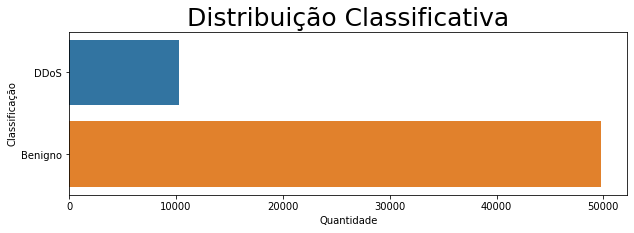

In [4]:
pyplot.subplots(figsize=(10, 3))
distribution = pd.DataFrame({"Classificação": ["DDoS","Benigno"],
                             "Quantidade":  [y_test.sum() , y_test.size - y_test.sum()]})
sns.barplot(data=distribution, y="Classificação", x="Quantidade").set_title("Distribuição Classificativa", fontsize=25)
pyplot.show()

In [5]:
testing_set = pd.DataFrame(testingSet)
testing_set.columns = header
corrmat = testing_set.corr()
top_corr_features = corrmat.index

In [6]:
#Features codificadas pelo label enconder: 17 16 7 4 2 1 0
#Feaatures sempre 0: 67, 66, 65, 64, 63, 62, 40, 39
#features com correlação próxima de zero, vide loop abaixo: 73, 71, 70, 50, 42, 34, 12, 10 
"""droppingList = [67, 66, 65, 64, 63, 62, 40, 39, 17, 16, 7, 4, 2, 1, 0]
droppedFeatures = droppingList

cm = testing_set[top_corr_features].corr().values
for i in (droppingList):
    testingSet = np.delete(testingSet, i, axis=1)
    header = np.delete(header, i, axis=0)
    
    cm = np.delete(cm, i, axis = 0)
    cm = np.delete(cm, i, axis = 1)

tolerance = 0.4
for i in range(cm.shape[0]-1, 0, -1):
    if cm[cm.shape[0]-1, i] >= -tolerance and cm[cm.shape[0]-1, i] <= tolerance:
        if i not in droppingList:
            droppedFeatures.append(i)
            testingSet = np.delete(testingSet, i, axis=1)
            header = np.delete(header, i, axis=0)
print("Features dropadas: ")
print(droppedFeatures)"""

'droppingList = [67, 66, 65, 64, 63, 62, 40, 39, 17, 16, 7, 4, 2, 1, 0]\ndroppedFeatures = droppingList\n\ncm = testing_set[top_corr_features].corr().values\nfor i in (droppingList):\n    testingSet = np.delete(testingSet, i, axis=1)\n    header = np.delete(header, i, axis=0)\n    \n    cm = np.delete(cm, i, axis = 0)\n    cm = np.delete(cm, i, axis = 1)\n\ntolerance = 0.4\nfor i in range(cm.shape[0]-1, 0, -1):\n    if cm[cm.shape[0]-1, i] >= -tolerance and cm[cm.shape[0]-1, i] <= tolerance:\n        if i not in droppingList:\n            droppedFeatures.append(i)\n            testingSet = np.delete(testingSet, i, axis=1)\n            header = np.delete(header, i, axis=0)\nprint("Features dropadas: ")\nprint(droppedFeatures)'

In [7]:
"""testing_set = pd.DataFrame(testingSet)
testing_set.columns = header
corrmat = testing_set.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(testingSet.shape[1], testingSet.shape[1]))
#plot heat map
g=sns.heatmap(testing_set[top_corr_features].corr(),annot=True,cmap="RdYlGn")
g.set_ylim(g.get_ylim()[0]+0.5, g.get_ylim()[1]-0.5)

testingSet = np.delete(testingSet, 84-len(droppedFeatures), axis=1)  #deleta o label
header = np.delete(header, 84-len(droppedFeatures), axis=0)"""

'testing_set = pd.DataFrame(testingSet)\ntesting_set.columns = header\ncorrmat = testing_set.corr()\ntop_corr_features = corrmat.index\nplt.figure(figsize=(testingSet.shape[1], testingSet.shape[1]))\n#plot heat map\ng=sns.heatmap(testing_set[top_corr_features].corr(),annot=True,cmap="RdYlGn")\ng.set_ylim(g.get_ylim()[0]+0.5, g.get_ylim()[1]-0.5)\n\ntestingSet = np.delete(testingSet, 84-len(droppedFeatures), axis=1)  #deleta o label\nheader = np.delete(header, 84-len(droppedFeatures), axis=0)'

In [8]:
#Aplica a padronização z-score
"""testingSetSaved = testingSet

mi = np.mean(testingSet)
sigma = np.std(testingSet)
testingSet = (testingSet - mi) / sigma"""

'testingSetSaved = testingSet\n\nmi = np.mean(testingSet)\nsigma = np.std(testingSet)\ntestingSet = (testingSet - mi) / sigma'

In [9]:
outliers_fraction = 0.17
def testMethod(clf, clf_name):
    clf.fit(testingSet)

    #####################################################################

    y_test_pred = clf.predict(testingSet)  # outlier labels (0 or 1)
    y_test_scores = clf.decision_function(testingSet)  # outlier scores

    #####################################################################

    print("\nOn Test Data - "+clf_name+":")
    truePositive = 0
    trueNegative = 0
    falsePositive = 0
    falseNegative = 0

    for i in range(y_test.size):
        if(y_test[i] == 1 and y_test_pred[i] == 1):
            truePositive = truePositive+1
        elif (y_test[i] == 0 and y_test_pred[i] == 0):
            trueNegative = trueNegative+1
        elif (y_test[i] == 0 and y_test_pred[i] == 1):
            falsePositive = falsePositive+1
        else:
            falseNegative = falseNegative+1

    print(truePositive, " | ", falsePositive)
    print(falseNegative, " | ", trueNegative,"\n")

    evaluate_print(clf_name, y_test, y_test_scores)

    #####################################################################

    fpr, tpr, threshold = metrics.roc_curve(y_test, y_test_scores)
    roc_auc = metrics.auc(fpr, tpr)

    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic - '+clf_name)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()



On Test Data - Fast ABOD:
574  |  9648
9682  |  40096 

Fast ABOD ROC:0.3426, precision @ rank n:0.0564


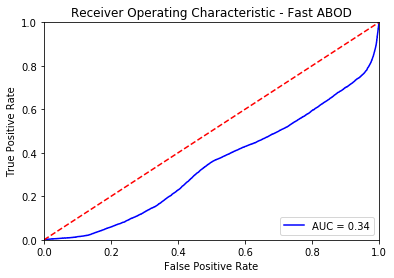


On Test Data - ABOD:
574  |  9648
9682  |  40096 

ABOD ROC:0.3426, precision @ rank n:0.0564


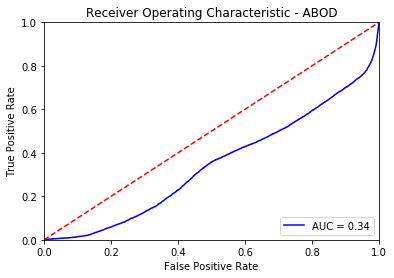

MemoryError: Unable to allocate array with shape (60000, 60000) and data type float64

In [12]:
#Probabilistic models
classifiers = {
    'Fast ABOD': ABOD(contamination= outliers_fraction, method="fast"),
    'ABOD': ABOD(contamination= outliers_fraction),
    'SOS': SOS(contamination= outliers_fraction)
}

for i, (clf_name, clf) in enumerate(classifiers.items()):
    testMethod(clf, clf_name)

In [13]:
from pyod.models.iforest import IForest
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.lscp import LSCP

C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\ensemble\iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)



On Test Data - Isolation Forest:
2000  |  8200
8256  |  41544 

Isolation Forest ROC:0.5853, precision @ rank n:0.1953


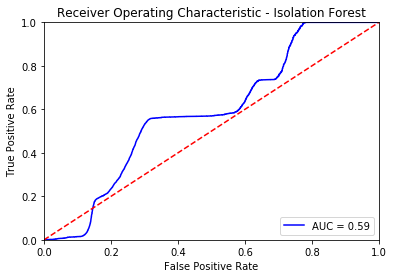


On Test Data - Feature Bagging:
867  |  8297
9389  |  41447 

Feature Bagging ROC:0.4074, precision @ rank n:0.0972


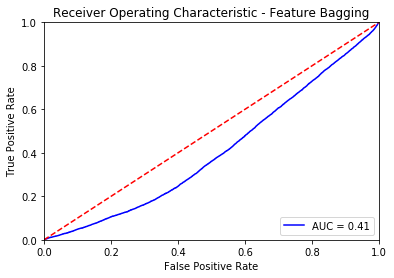

In [15]:
#Ensembles models
classifiers = {
    'Isolation Forest': IForest(contamination= outliers_fraction),
    'Feature Bagging': FeatureBagging(contamination= outliers_fraction)
    #,'LSCP': LSCP(contamination= outliers_fraction)
}

for i, (clf_name, clf) in enumerate(classifiers.items()):
    testMethod(clf, clf_name)